In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
import plotly.express as px
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('datathon4.csv')
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [3]:
data = data.dropna(axis=1, thresh=data.shape[0] * (3/4))
data = data.dropna()
print(data.shape)

(27795, 112)


In [4]:
# outcome is very unbalanced

print(data.groupby('hospital_death').size()) 

hospital_death
0    25259
1     2536
dtype: int64


In [5]:
# Create a subset with manual feature selection
df = data.drop(['encounter_id', 'patient_id', 'hospital_id','icu_id',
               'apache_3j_bodysystem', 'apache_2_bodysystem', 'readmission_status', 
                'apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob'], axis=1)

non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric_columns)

unique_values = df[non_numeric_columns].nunique()
print(unique_values)

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']
ethnicity                 6
gender                    2
hospital_admit_source    15
icu_admit_source          5
icu_stay_type             3
icu_type                  8
dtype: int64


In [6]:
le = LabelEncoder()

# Apply Label Encoding to each categorical column
df_encoded = df.copy()
for column in non_numeric_columns:
    df_encoded[column] = le.fit_transform(df_encoded[column])

# Check that the Label Encoding has worked properly

unique_values = df_encoded[non_numeric_columns].nunique()
print(unique_values)

non_numeric_columns = df_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric_columns)

ethnicity                 6
gender                    2
hospital_admit_source    15
icu_admit_source          5
icu_stay_type             3
icu_type                  8
dtype: int64
[]


In [7]:
# Feature selection

# Variance threshold
selector = VarianceThreshold(threshold = 0)
selector.fit(df_encoded)

VarianceThreshold(threshold=0)

In [8]:
mask = selector.get_support()
df_encoded_variance_threshold = df_encoded.loc[:, mask]

df_encoded_variance_threshold.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,...,d1_wbc_max,d1_wbc_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,0,68.0,22.730000,0,2,1,180.3,4,1,0,...,14.1,14.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,77.0,27.420000,0,2,0,160.0,4,1,0,...,23.3,12.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0,67.0,27.560000,0,2,1,190.5,2,0,0,...,10.9,10.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
17,0,46.0,25.845717,0,3,1,167.6,3,0,0,...,9.7,9.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0,87.0,21.963763,0,2,1,180.3,4,1,0,...,9.9,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Feature vs label

X = df_encoded_variance_threshold.drop('hospital_death', axis=1)
y = df_encoded_variance_threshold['hospital_death']

print(X.shape, y.shape)

(27795, 101) (27795,)


<Axes: >

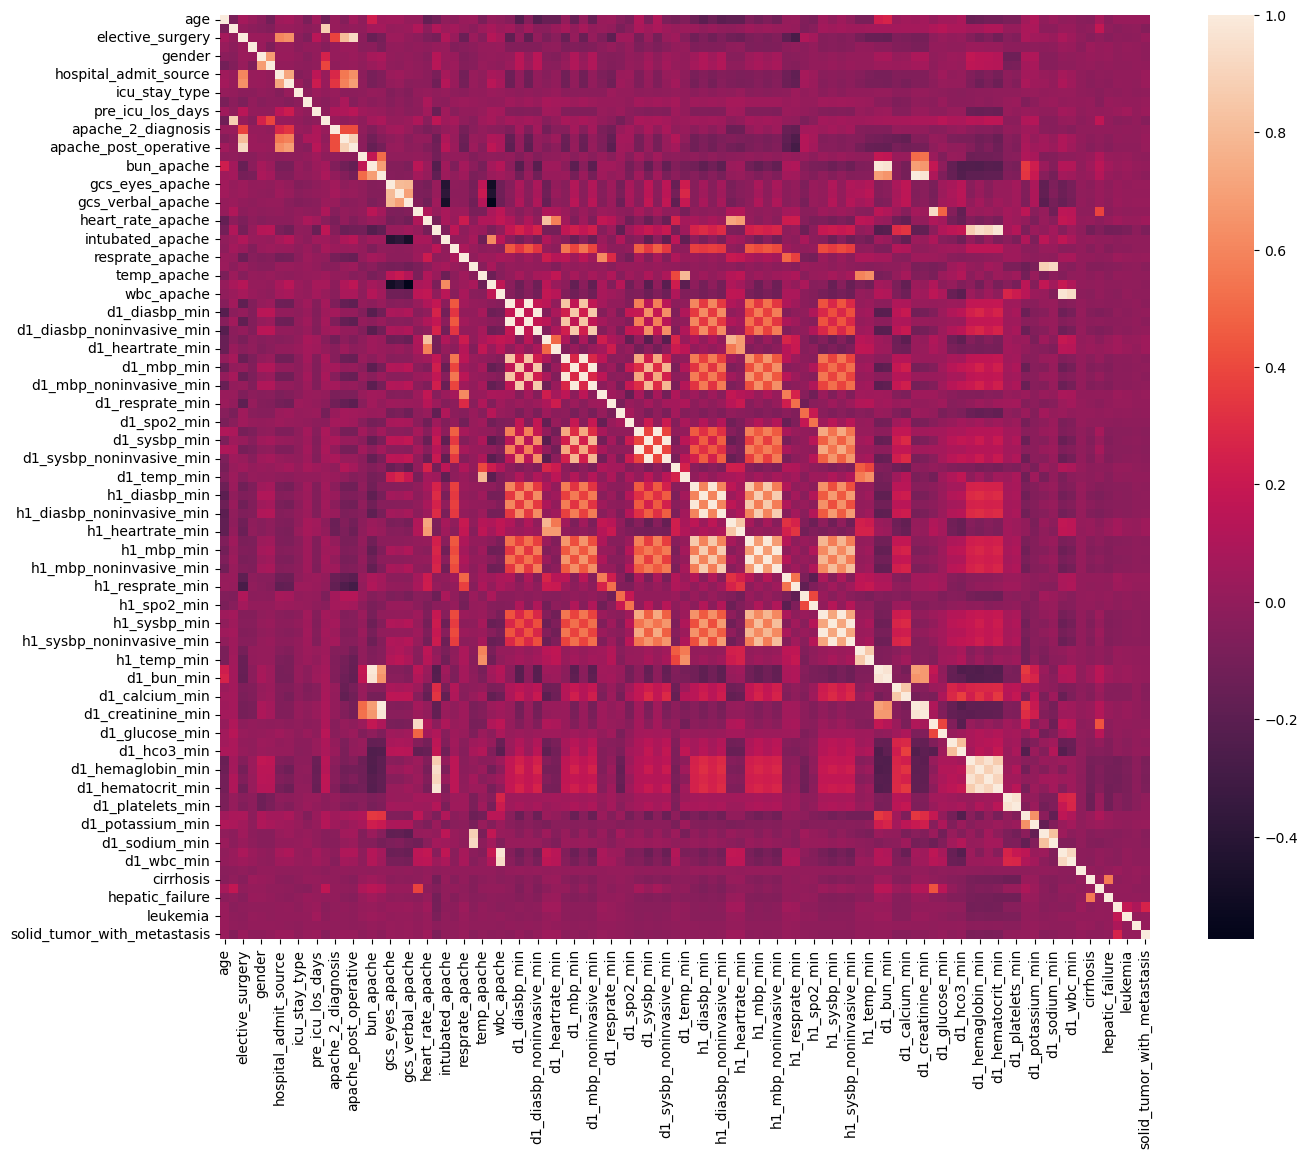

In [10]:
#Plotting the correlation heatmap
correlation_matrix = X.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix)

In [11]:
multicollinear_cols = set()

for i in range (len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i,j]) > 0.7:
      multicollinear_cols.add(correlation_matrix.columns[i])

print(len(multicollinear_cols))

47


In [12]:
X.drop(labels=multicollinear_cols, axis = 1, inplace=True)
X.shape

(27795, 54)

In [23]:
# Split the features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [32]:
# Scaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [ ]:
# cv = KFold(n_splits=5)
# rfr = RandomForestRegressor()
# rfecv = RFECV(estimator=rfr, cv=cv, step=1)
# rfecv.fit(X_train, y_train)

# # Get the selected features
# rfecv_features_regression = X_train.columns[rfecv.get_support()]

# print(rfecv_features_regression)

In [37]:
# Resampling

ros = RandomOverSampler()
x_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
x_val_resampled, y_val_resampled = ros.fit_resample(X_val, y_val)

# Initializing the XGBoost Classifier with specified parameters
model = GradientBoostingClassifier(n_estimators = 100, learning_rate=1.0, max_depth=1)

In [ ]:
# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "n_estimators" : [100, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [25, 50],
    "learning_rate" : [.1,  .2]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Fitting the GridSearchCV on the training data
random_search.fit(x_val_resampled, y_val_resampled)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

In [36]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(x_train_resampled, y_train_resampled)

# Predicting on the training dataset and computing the accuracy
Y_pred_train = model.predict(x_train_resampled)
accuracy_score(y_train_resampled, Y_pred_train)

# Predicting on the test dataset and computing the accuracy
Y_pred_test = model.predict(X_test)
accuracy_score(y_test, Y_pred_test)

0.88864903759669

In [35]:
# Performance report

print(classification_report(Y_pred_train, y_train_resampled))
print(classification_report(Y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15956
           1       1.00      0.99      0.99     16398

    accuracy                           0.99     32354
   macro avg       0.99      0.99      0.99     32354
weighted avg       0.99      0.99      0.99     32354

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4978
           1       0.48      0.43      0.45       581

    accuracy                           0.89      5559
   macro avg       0.71      0.69      0.70      5559
weighted avg       0.89      0.89      0.89      5559

